In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/khai/malist_project/piano-transcribe


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio
from pathlib import Path
import numpy as np
import mathplotlib

from src.data.audio import onf_transform
from src.data.datasets import MAPSDataset
from src.data.audio import MadmomSpectrogram
from src.data.data_modules import MAPSDataModule
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_multilabel_classification
from src.eval import compute_frame_metrics

In [14]:
# audio_transform = MadmomSpectrogram(hop_length=441*4, sample_rate=16000)
mapsDataModule = MAPSDataModule(batch_size=4, 
                                max_steps=5, 
                                sample_rate=16000, 
                                audio_transform=onf_transform, 
                                lazy_loading=True,
                                hop_length = 512)

In [15]:
# setup data 
mapsDataModule.setup()

In [16]:
train_loader = mapsDataModule.train_dataloader()
validate_loader = mapsDataModule.val_dataloader()
test_loader = mapsDataModule.test_dataloader()

In [51]:
# # train_loader.dataset[0]['frames'].shape
# for batch in train_loader: 
#     print(batch['audio'][3])
#     break

batch['audio'].shape[2]

229

In [21]:
clf = MultiOutputClassifier(SGDClassifier(loss='log'))
for i_batch,batch in enumerate(train_loader):
    batch_input = torch.reshape(batch['audio'], [batch['audio'].shape[0], batch['audio'].shape[2]])
    batch_output = batch['frames'][:,2,:]
    clf.partial_fit(batch_input.numpy(), batch_output.numpy().astype(np.int), classes=[np.array([0,1]) for i in range(88)])

In [25]:
sample_metrics = []
for batch in validate_loader:
    batch_input = torch.reshape(batch['audio'], [batch['audio'].shape[0], 5*229])
    batch_output = batch['frames'][:,2,:]
    batch_pred = clf.predict(batch_input.numpy())
    dict_score = compute_frame_metrics(batch_pred.flatten(), batch_output.numpy().astype(int).flatten())
    sample_metrics.append(dict_score)

[{'frame': {'precision': 0.9147727272727273, 'recall': 0.9147727272727273, 'f1': 0.9147727272727273}}, {'frame': {'precision': 0.9261363636363636, 'recall': 0.9261363636363636, 'f1': 0.9261363636363636}}, {'frame': {'precision': 0.9147727272727273, 'recall': 0.9147727272727273, 'f1': 0.9147727272727273}}, {'frame': {'precision': 0.9176136363636364, 'recall': 0.9176136363636364, 'f1': 0.9176136363636364}}, {'frame': {'precision': 0.9318181818181818, 'recall': 0.9318181818181818, 'f1': 0.9318181818181818}}, {'frame': {'precision': 0.9232954545454546, 'recall': 0.9232954545454546, 'f1': 0.9232954545454546}}, {'frame': {'precision': 0.9232954545454546, 'recall': 0.9232954545454546, 'f1': 0.9232954545454546}}, {'frame': {'precision': 0.9488636363636364, 'recall': 0.9488636363636364, 'f1': 0.9488636363636364}}]


SyntaxError: invalid syntax (<ipython-input-31-398513f134df>, line 4)

In [27]:
sample_metrics[0]

{'frame': {'precision': 0.9147727272727273,
  'recall': 0.9147727272727273,
  'f1': 0.9147727272727273}}

In [10]:
svm_clf = MultiOutputClassifier(SGDClassifier(loss='hinge'))
for i_batch,batch in enumerate(train_loader):
    batch_input = torch.reshape(batch['audio'], [4, 5*294])
    batch_output = batch['frames'][:,2,:]
    svm_clf.partial_fit(batch_input.numpy(), batch_output.numpy().astype(np.int), classes=[np.array([0,1]) for i in range(88)])

In [11]:
accuracy = 0
for batch in validate_loader:
    batch_input = torch.reshape(batch['audio'], [batch['audio'].shape[0], 5*294])
    batch_output = batch['frames'][:,2,:]
    batch_pred = svm_clf.predict(batch_input.numpy())
    accuracy += accuracy_score(batch_output.numpy().astype(int).flatten(), batch_pred.flatten())

print('Average accurary: ', accuracy/len(validate_loader))

Average accurary:  0.9019886363636365


In [46]:
import matplotlib.pyplot as plt

def plot(sample_metrics): 
    frames = [i for i in range(len(sample_metrics))]
    precisions = [i['frame']['precision'] for i in sample_metrics]
    recalls = [i['frame']['recall'] for i in sample_metrics]    
    f1 = [i['frame']['f1'] for i in sample_metrics]    
    plt.plot(frames, precisions, 'r', label='precisions')
    plt.plot(frames, recalls, 'b', label='recalls')
    plt.plot(frames, f1, 'g', label='f1')
    plt.legend()
    plt.xlabel('Frames')
    plt.ylabel('Values')
    plt.title('Data evaluation')
    plt.show()

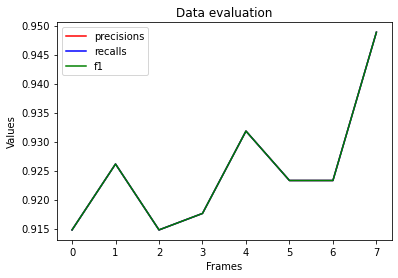

In [47]:
plot(sample_metrics)